In [33]:
import os
os.environ['THEANO_FLAGS'] = 'device=cpu'
import pandas as pd 
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [36]:
data = pd.read_csv('data.csv')
data["Actual_Force"] = data["As"].diff(1) / 0.004
data["Film_Force"] = data["pAs"].diff(1) / 0.004
data.fillna(0, inplace=True)
conditions = [(data['Tot_RUL'] <= 100000),
    (data['Tot_RUL'] >= 100000)]
choices = [0.0, 1.0]
data["label"] = np.select(conditions, choices, default=0)
data

timestamp        MT  Lag_error         AP           As        pAp  \
0         0.008000  0.670726  -0.050846  939333465 -6674.194336  409999463   
1         0.012000  0.456506   0.003138  939333438 -6794.356934  409999513   
2         0.016000  0.520841   0.005510  939333411 -6749.725098  409999562   
3         0.020000  0.568736  -0.028143  939333384 -6780.624023  409999611   
4         0.024000  0.576378  -0.028126  939333357 -6763.458008  409999661   
...            ...       ...        ...        ...          ...        ...   
1062907   8.179999  0.369686  -1.367144    5530159  9352.111328   18877402   
1062908   8.183999 -0.330580  -0.919746    5530195  9094.619141   18877422   
1062909   8.187999  0.063502  -0.746151    5530231  9005.355469   18877443   
1062910   8.191999 -0.211253  -0.460982    5530267  8912.658203   18877463   
1062911   8.195999 -0.130315  -0.329030    5530303  8912.658203   18877484   

                  pAs       ple          vax  mode  sample  cycle   RUL  \
0        12294.263672  1.043955  2699.999512     0     0.0      1  2047   
1        12269.095703  1.066463  2699.999512     0     0.0      2  2046   
2        12261.545898  1.120736  2699.999512     0     0.0      3  2045   
3        12286.712891  1.180041  2699.999512     0     0.0      4  2044   
4        12281.679688  1.163287  2699.999512     0     0.0      5  2043   
...               ...       ...          ...   ...     ...    ...   ...   
1062907   5212.163574  0.567995  1799.999756     4   493.0   2044     4   
1062908   5144.211914  0.417207  1799.999756     4   493.0   2045     3   
1062909   5106.460449  0.341877  1799.999756     4   493.0   2046     2   
1062910   5141.695312  0.400728  1799.999756     4   493.0   2047     1   
1062911   5043.541992  0.366364  1799.999756     4   493.0   2048     0   

         tot_cycle  Tot_RUL  Actual_Force    Film_Force  label  
0                1   204799      0.000000      0.000000    1.0  
1                2   204798 -30040.649415  -6291.992188    1.0  
2                3   204797  11157.958985  -1887.451172    1.0  
3                4   204796  -7724.731445   6291.748047    1.0  
4                5   204795   4291.503905  -1258.300780    1.0  
...            ...      ...           ...           ...    ...  
1062907     204796        4 -15449.462890 -27684.082033    0.0  
1062908     204797        3 -64373.046875 -16987.915037    0.0  
1062909     204798        2 -22315.917967  -9437.866213    0.0  
1062910     204799        1 -23174.316408   8808.715823    0.0  
1062911     204800        0      0.000000 -24538.330080    0.0  

[1062912 rows x 18 columns]

In [37]:
for i in data:
    data[i] = (data[i] - data[i].min()) / (data[i].max() - data[i].min())
data

timestamp        MT  Lag_error        AP        As       pAp  \
0         0.000488  0.694145   0.469952  0.753861  0.102455  0.281949   
1         0.000976  0.673581   0.483759  0.753861  0.098071  0.281949   
2         0.001464  0.679757   0.484366  0.753861  0.099699  0.281949   
3         0.001952  0.684354   0.475758  0.753861  0.098572  0.281949   
4         0.002440  0.685088   0.475763  0.753861  0.099198  0.281949   
...            ...       ...        ...       ...       ...       ...   
1062907   0.997560  0.665246   0.133285  0.517506  0.687124  0.012855   
1062908   0.998048  0.598024   0.247715  0.517506  0.677730  0.012855   
1062909   0.998536  0.635854   0.292115  0.517506  0.674474  0.012855   
1062910   0.999024  0.609479   0.365052  0.517506  0.671092  0.012855   
1062911   0.999512  0.617249   0.398801  0.517506  0.671092  0.012855   

              pAs       ple   vax  mode    sample     cycle       RUL  \
0        0.684431  0.436906  0.75   0.0  0.000000  0.000000  1.000000   
1        0.683033  0.441928  0.75   0.0  0.000000  0.000489  0.999511   
2        0.682613  0.454036  0.75   0.0  0.000000  0.000977  0.999023   
3        0.684012  0.467267  0.75   0.0  0.000000  0.001466  0.998534   
4        0.683732  0.463530  0.75   0.0  0.000000  0.001954  0.998046   
...           ...       ...   ...   ...       ...       ...       ...   
1062907  0.290810  0.330718  0.50   0.8  0.951737  0.998046  0.001954   
1062908  0.287033  0.297077  0.50   0.8  0.951737  0.998534  0.001466   
1062909  0.284935  0.280271  0.50   0.8  0.951737  0.999023  0.000977   
1062910  0.286893  0.293401  0.50   0.8  0.951737  0.999511  0.000489   
1062911  0.281438  0.285734  0.50   0.8  0.951737  1.000000  0.000000   

         tot_cycle   Tot_RUL  Actual_Force  Film_Force  label  
0         0.000000  1.000000      0.534872    0.504908    1.0  
1         0.000005  0.999995      0.531869    0.504040    1.0  
2         0.000010  0.999990      0.535987    0.504648    1.0  
3         0.000015  0.999985      0.534100    0.505777    1.0  
4         0.000020  0.999980      0.535301    0.504735    1.0  
...            ...       ...           ...         ...    ...  
1062907   0.999980  0.000020      0.533328    0.501086    0.0  
1062908   0.999985  0.000015      0.528438    0.502563    0.0  
1062909   0.999990  0.000010      0.532641    0.503605    0.0  
1062910   0.999995  0.000005      0.532556    0.506125    0.0  
1062911   1.000000  0.000000      0.534872    0.501520    0.0  

[1062912 rows x 18 columns]

In [38]:
df_1 = data.drop(['mode','cycle','RUL','tot_cycle','Tot_RUL'], axis = 1, inplace = True)
df_1

In [39]:
df_1 = data.groupby('sample')['timestamp','MT','Lag_error','AP','As','pAp','pAs','ple','vax','Actual_Force','Film_Force','label'].mean()


In [40]:
df_1

timestamp        MT  Lag_error        AP        As       pAp  \
sample                                                                   
0.000000        0.5  0.618459   0.482906  0.714512  0.414849  0.142747   
0.001931        0.5  0.615477   0.482880  0.675180  0.401803  0.003657   
0.003861        0.5  0.627692   0.482956  0.675246  0.369453  0.004102   
0.005792        0.5  0.618644   0.482993  0.675291  0.393608  0.004399   
0.007722        0.5  0.619550   0.482976  0.675330  0.395836  0.004666   
...             ...       ...        ...       ...       ...       ...   
0.992278        0.5  0.619840   0.483278  0.525234  0.403923  0.062821   
0.994208        0.5  0.609040   0.482936  0.562443  0.411884  0.146762   
0.996139        0.5  0.609125   0.483226  0.563157  0.412439  0.152264   
0.998069        0.5  0.614270   0.483080  0.565019  0.414363  0.005201   
1.000000        0.5  0.619015   0.482783  0.565443  0.392775  0.007902   

               pAs       ple       vax  Actual_Force  Film_Force  label  
sample                                                                   
0.000000  0.329979  0.413408  0.561214      0.534804    0.504886    1.0  
0.001931  0.165897  0.390711  0.333333      0.534938    0.504851    1.0  
0.003861  0.152391  0.387197  0.346282      0.534850    0.504867    0.0  
0.005792  0.181512  0.396141  0.383333      0.534879    0.504951    1.0  
0.007722  0.188031  0.395642  0.383333      0.534824    0.504910    0.0  
...            ...       ...       ...           ...         ...    ...  
0.992278  0.191367  0.402980  0.416667      0.534827    0.504917    0.0  
0.994208  0.284413  0.416168  0.500000      0.534802    0.504894    0.0  
0.996139  0.282623  0.410013  0.500000      0.534799    0.504905    0.0  
0.998069  0.195355  0.395886  0.416667      0.534767    0.504861    0.0  
1.000000  0.201757  0.398486  0.416667      0.534911    0.504928    0.0  

[518 rows x 12 columns]

In [ ]:
The likelihood of the data given regression coefficients β and covariates Xi is Yi ∼ N(βTXi,σ2)
• β∼N(0,10)
• σ2 ∼ InverseGamma(0.1, 0.1)

In [59]:
Deterministic_model = pm.Model()
with Deterministic_model:
    intercept = pm.Normal('intercept')
    beta     = pm.Normal('beta',shape=len(predictors))
    variance  = pm.InverseGamma('variance',alpha=0.1,beta=0.1)
    sd        = pm.Deterministic('sd',variance**0.5)
    yhat = pm.Deterministic('yhat',intercept + pm.math.dot(df_1[predictors],beta))
    y    = pm.Normal('y',mu=yhat,sd=sd, observed=df_1['timestamp'])

In [60]:
with Deterministic_model:
    trace_1 = pm.sample(chains = 2, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [variance, beta, intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [02:06<00:00, 15.81draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/RishJain04/opt/anaconda3/lib/python3.7/site-packages/pymc3/plots/forestplot.py:318: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/Users/RishJain04/opt/anaconda3/lib/python3.7/site-packages/pymc3/plots/forestplot.py:319: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


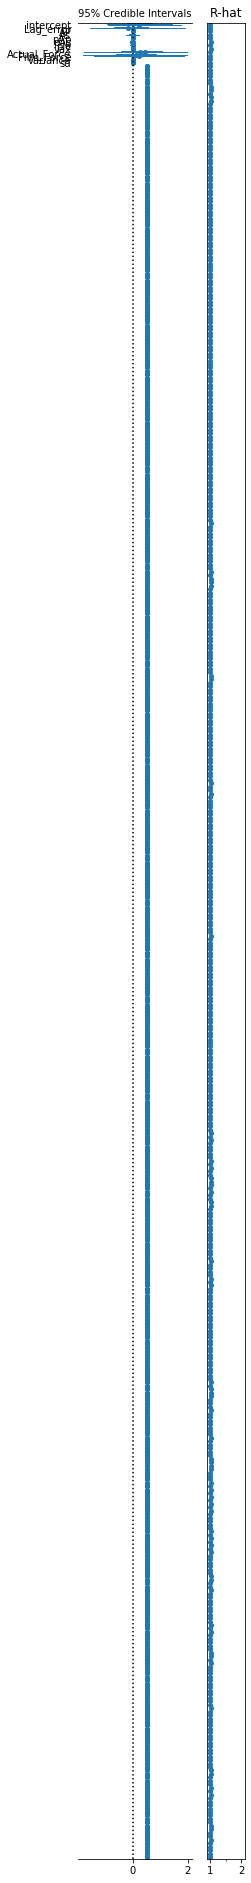

In [61]:
plt.figure(figsize=(3,30))
pm.forestplot(trace_1,ylabels=['intercept'] + predictors + ['variance','sd']);

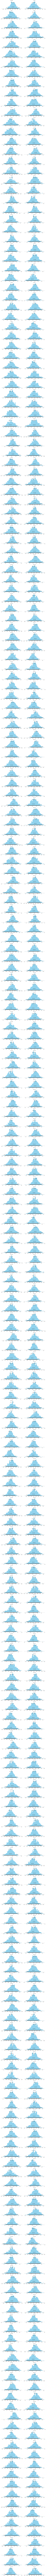

In [10]:
pm.plot_posterior(trace_1);

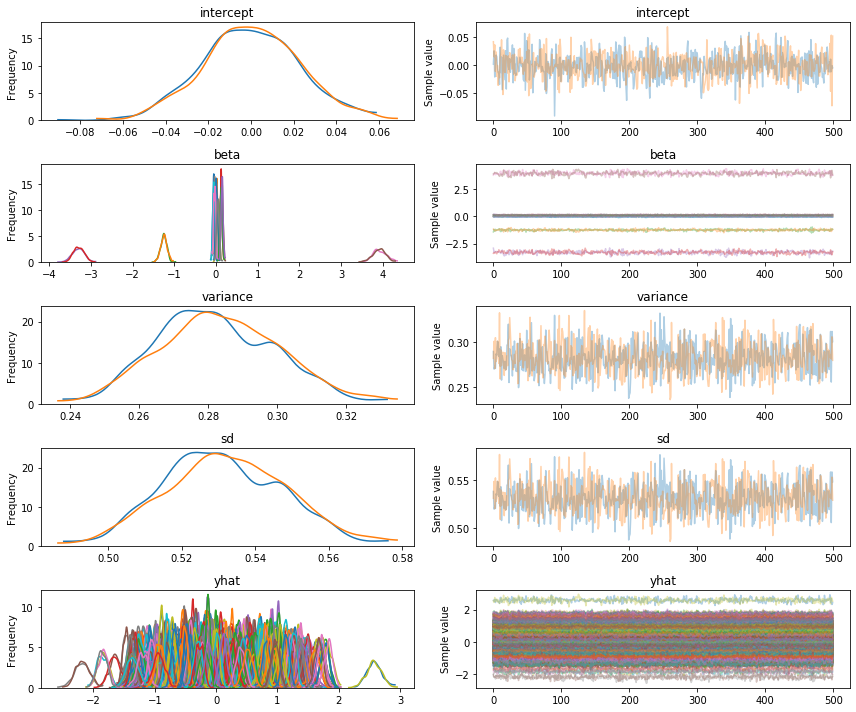

In [11]:
pm.traceplot(trace_1);

In [ ]:
predictors = ['MT','Lag_error','AP','As','pAp','pAs','ple','vax','Actual_Force','Film_Force']

In [47]:
Interact_model = pm.Model()

index = list(range(45))
n =0
new_df = pd.DataFrame()
for i in range (len(predictors)):
    for j in range(i,len(predictors)):
        index[n] = predictors[i] + predictors[j]
        new_df[index[n]]= df_1[predictors[i]].mul(df_1[predictors[j]])
        n +=1
new_df = (new_df - new_df.mean())/new_df.std()
print(new_df)
with Interact_model:
    intercept = pm.Normal('intercept')
    beta1 = pm.Normal('beta1',shape=len(predictors))
    beta2 = pm.Normal('beta2',shape=45)
    variance = pm.InverseGamma('variance', alpha = 0.1 ,beta = 0.1)
    sd = pm.Deterministic('sd',variance**0.5)
    yhat = intercept + pm.math.dot(df_1[predictors],beta1) + pm.math.dot(new_df[index],beta2)
    yhat1 = pm.Deterministic('yhat1', yhat)
    y    = pm.Normal('y',mu=yhat,sd=sd, observed=df_1['timestamp'])
    
    trace = pm.sample()

          Lag_errorLag_error  Lag_errorAP  Lag_errorAs  Lag_errorpAp  \
sample                                                                 
0.000000           -0.314171     0.817424    -0.086045      0.217321   
0.001931           -0.535086     0.533257    -0.617919     -0.527749   
0.003861            0.114035     0.534502    -1.932153     -0.525363   
0.005792            0.427687     0.535193    -0.947702     -0.523767   
0.007722            0.285256     0.535311    -0.857558     -0.522339   
...                      ...          ...          ...           ...   
0.992278            2.863285    -0.545904    -0.518105     -0.210564   
0.994208           -0.055247    -0.279988    -0.205680      0.238877   
0.996139            2.423019    -0.272389    -0.172992      0.268839   
0.998069            1.170518    -0.260179    -0.099758     -0.519465   
1.000000           -1.360910    -0.259629    -0.988561     -0.505017   

          Lag_errorpAs  Lag_errorple  Lag_errorvax  Lag_errorAc

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [variance, beta2, beta1, intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [03:27<00:00,  9.65draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


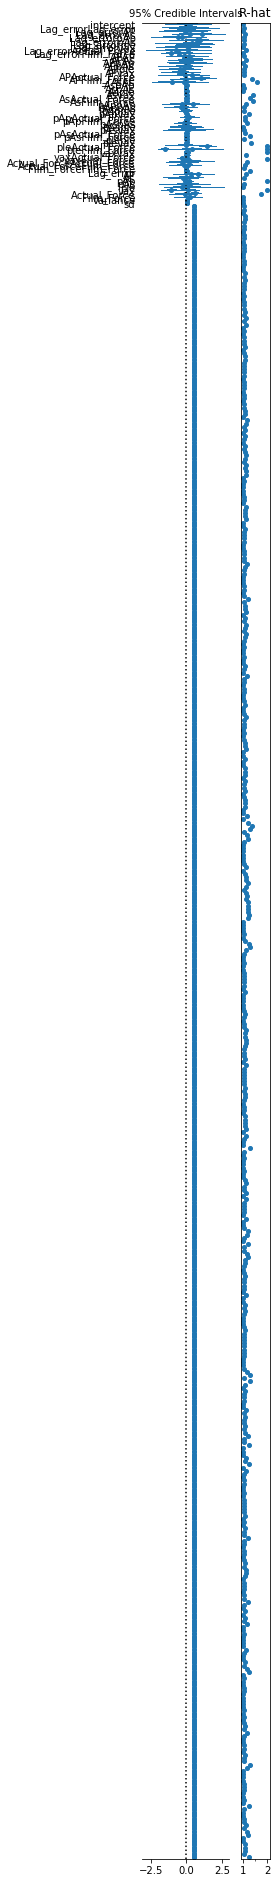

In [48]:
plt.figure(figsize=(3,30))
pm.forestplot(trace,ylabels=['intercept'] + index + predictors + ['variance','sd']);

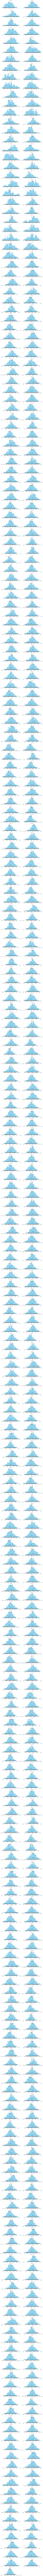

In [44]:
pm.plot_posterior(trace);

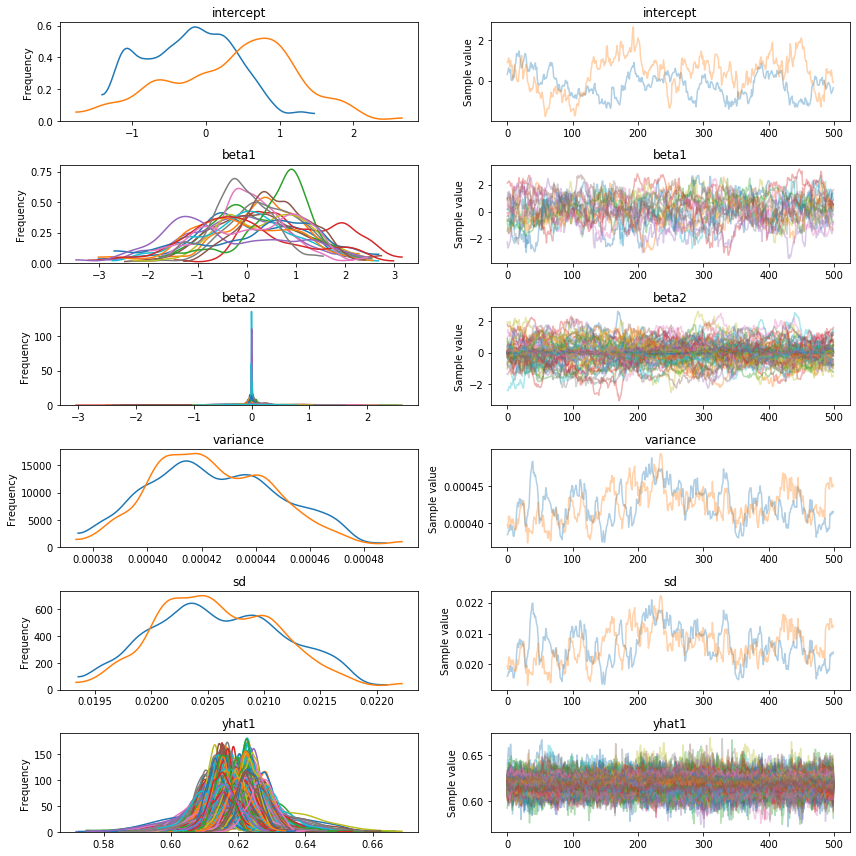

In [45]:
pm.traceplot(trace);

In [55]:
R2_2NDorder = pm.stats.r2_score(df_1['MT'].values.reshape(1,518), trace['yhat1'], round_to=2)
WAIC_2NDorder = pm.stats.waic(trace,model = Interact_model)
print(R2_2NDorder)
print(WAIC_2NDorder)

r2_r(r2_median=0.35, r2_mean=0.35, r2_std=0.05)
WAIC_r(WAIC=-3063.3529197382554, WAIC_se=1.4205358166204411, p_WAIC=2.028159800995757, var_warn=0)


In [63]:
R2_1order = pm.r2_score(df_1['MT'].values.reshape(1,518),trace_1['yhat'])
WAIC_1order = pm.stats.waic(trace_1,model = Deterministic_model)
print(R2_1order)
print(WAIC_1order)

r2_r(r2_median=0.15, r2_mean=0.17, r2_std=0.09)
WAIC_r(WAIC=-3099.577072426623, WAIC_se=0.2331835855115458, p_WAIC=0.5802790107886826, var_warn=0)


In [49]:
import patsy
y , X = patsy.dmatrices('MT ~ Lag_error + AP + As + pAp + pAs + ple + vax ', df_1)
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, y,
                                                    test_size=0.1,
                                                    train_size=0.1,
                                                    random_state=2000)

In [50]:
from sklearn.linear_model import LinearRegression
my_model = LinearRegression()
my_model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [51]:
my_model.score(X_test, Y_test)

0.5408927912043413

In [52]:
my_predictions = my_model.predict(X_test)
my_predictions

array([[0.61753532],
       [0.61417251],
       [0.6209278 ],
       [0.61704779],
       [0.61836613],
       [0.61787187],
       [0.61609285],
       [0.61491605],
       [0.6203659 ],
       [0.61430349],
       [0.61628624],
       [0.61333454],
       [0.61513078],
       [0.61280394],
       [0.61708108],
       [0.61758717],
       [0.6171375 ],
       [0.61774192],
       [0.61364778],
       [0.61923982],
       [0.62396246],
       [0.61732913],
       [0.61778827],
       [0.61724234],
       [0.61725539],
       [0.61683986],
       [0.61778271],
       [0.62014186],
       [0.61527888],
       [0.61629496],
       [0.62115539],
       [0.62230549],
       [0.61713788],
       [0.61298054],
       [0.62406286],
       [0.61491322],
       [0.61717455],
       [0.61909259],
       [0.62148984],
       [0.62224838],
       [0.62378151],
       [0.61754984],
       [0.61836744],
       [0.61799738],
       [0.61404634],
       [0.62368665],
       [0.6174196 ],
       [0.619